In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import statsmodels.api as sm

import re

import pymc_extras.statespace as pmss

config = {
    "figure.figsize": [12.0, 4.0],
    "figure.dpi": 72.0 * 2,
    "figure.facecolor": "w",
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)


def sample_kwargs(mode="numba"):
    return {
        "nuts_sampler": "nutpie",
        "cores": 8,
        "draws": 250,
        "tune": 500,
    }

In [2]:
def plot_eigenvalues(eigs, include_kde=False, cmap=None):
    if cmap is None:
        cmap = plt.cm.tab20

    n, k = eigs.shape

    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(aspect="equal"))
    circ = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(circ), np.sin(circ), c="k", ls="--", lw=0.5)

    real_part = eigs.real.ravel()
    imag_part = eigs.imag.ravel()
    if include_kde:
        sns.kdeplot(x=real_part, y=imag_part, ax=ax, fill=True)

    scatter = ax.scatter(
        real_part, imag_part, c=np.tile(np.arange(k), n), cmap=cmap, alpha=0.35, s=10
    )
    fig.legend(*scatter.legend_elements(), loc="center left", bbox_to_anchor=(1.0, 0.5))
    fig.tight_layout()
    plt.show()


def plot_posterior_timeseries(
    idata, state, filter_output=None, data=None, ax=None, add_legend=False
):
    if ax is None:
        fig, ax = plt.subplots()

    if filter_output is not None:
        f_name = f"{filter_output}_posterior"
        idata = idata[f_name]
        hdi = az.hdi(idata).sel(state=state)[f_name]

    else:
        hdi = az.hdi(idata).sel(state=state)

    post = idata.sel(state=state).stack(sample=["chain", "draw"])

    x_grid = post.coords["time"]
    mean = post.mean(dim=["sample"]).values

    ax.plot(x_grid, mean, label=filter_output)
    ax.fill_between(x_grid, *hdi.values.T, color="tab:blue", alpha=0.25)
    ax.set(title=state, xlabel="Time")

    if data is not None:
        ax.plot(data.index, data[state].values, color="k", lw=1, ls="--", label="Data")

    if add_legend:
        ax.legend()

# Introduction

For a general introduction on VAR modeling, see the example on Bayesian VAR modeling here: https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html

This notebook will implement the same model, using the `pymc_extras.statespace` package. In most cases, the two approaches will be the same.

# Data

For data, we will use a sample dataset distributed with Statsmodels, and used in their [example on VAR modeling](https://www.statsmodels.org/stable/vector_ar.html). 

In [3]:
mdata = sm.datasets.macrodata.load_pandas().data
mdata.index = pd.DatetimeIndex(
    mdata[["year", "quarter"]].map(lambda x: str(int(x))).apply(lambda x: "Q".join(x), axis=1)
)
data = mdata[["realgdp", "realcons", "realinv"]].apply(np.log).diff().dropna()
data = (data - data.mean()) / data.std()
data.index.freq = data.index.inferred_freq

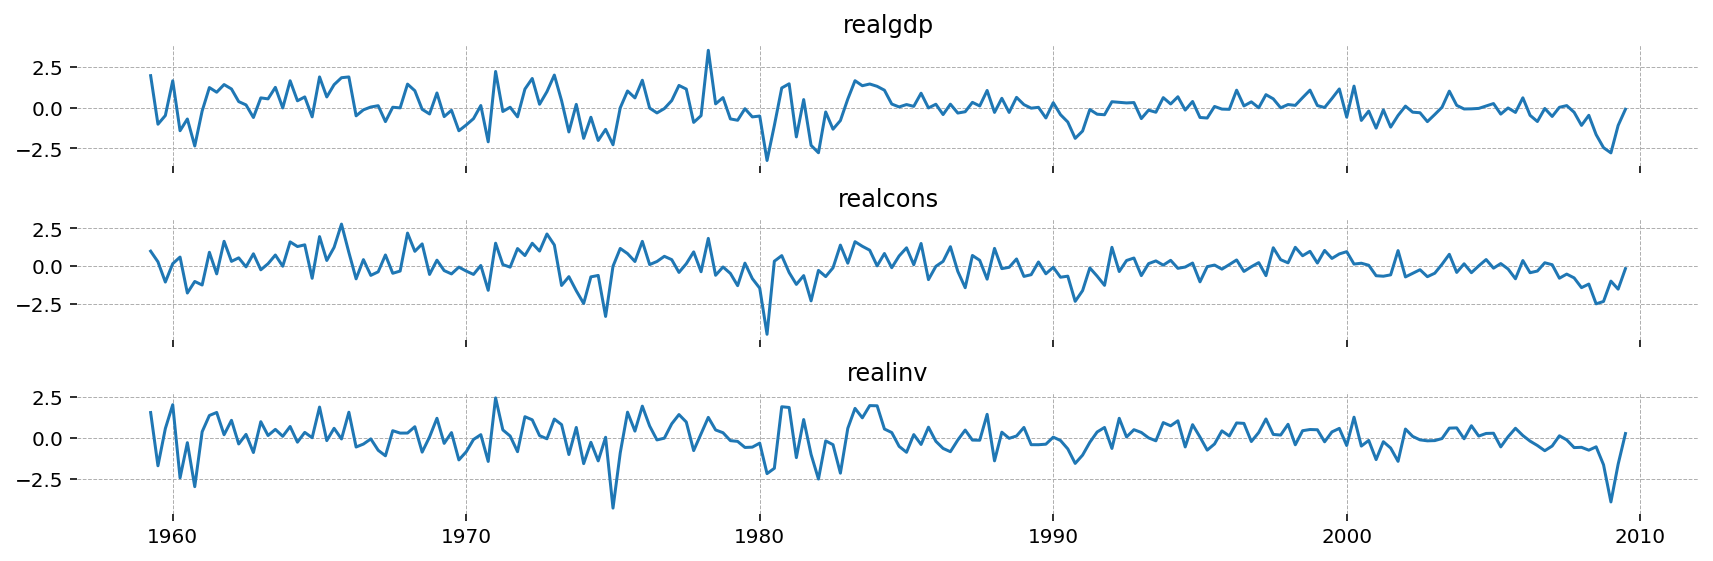

In [4]:
fig, ax = plt.subplots(3, 1, sharex=True)
for var, axis in zip(data, fig.axes):
    axis.plot(data[var])
    axis.set(title=var)
fig.tight_layout()
plt.show()

## Statsmodels Baseline

TODO: Add some commentary

In [5]:
sm_mod = sm.tsa.VARMAX(data, order=(2, 0), trend="n")
sm_res = sm_mod.fit(disp=0)
# sm_res.summary()

# PyMC Statespace

To fit a VAR model with `pymc-statespace`, use the `BayesianVARMAX` model. We will receive a message giving the names of the parameters we need to set priors for. In this case, we need:

- `x0`, a guess at the initial state of the system. 
- `P0`, a guess at the initial covariance of the system
- `ar_params`, the autoregressive parameters
- `state_cov`, the covariance matrix of the shocks to the system

Note that statsmodels only estimated `ar_params` and `state_cov`. They handle *initialization* of the Kalman Filter, that is, selection of `x0` and `P0`, using other methods. Since we're in a Bayesian framework, though, nothing stops us from estimating these parameters. `x0` is clearly going to be centered on zero. `P0` is a bit more abstract. We could remove it by doing some linear algebra - you can ask for this by setting `stationary_initialzation = True`. This option is currently not supported in JAX, though, so we have to do it a harder way.

In [6]:
bvar_mod = pmss.BayesianVARMAX(
    endog_names=data.columns,
    order=(2, 0),
    stationary_initialization=False,
    measurement_error=False,
    filter_type="standard",
    verbose=True,
    mode="NUMBA",
)

                                          Model Requirements                                           
                                                                                                       
  Variable    Shape       Constraints                                                      Dimensions  
 ───────────────────────────────────────────────────────────────────────────────────────────────────── 
  x0          (6,)                                                                         ('state',)  
  P0          (6, 6)      Positive Semi-definite                               ('state', 'state_aux')  
  ar_params   (3, 2, 3)                            ('observed_state', 'lag_ar', 'observed_state_aux')  
  state_cov   (3, 3)      Positive Semi-definite                               ('shock', 'shock_aux')  
                                                                                                       
        These parameters should be assigned priors inside a PyMC model block before calling the        
                                    build_statespace_graph method.                                     

### Dim and Coord Helpers

Models in `pmx.statespace` come with properties that help assign the necessary coords and dims in a PyMC model. These are `statespace.coords` and `statespace.param_dims`. Here they are for the VAR model:

In [7]:
bvar_mod.param_dims.values()

dict_values([('state',), ('state', 'state_aux'), ('observed_state', 'lag_ar', 'observed_state_aux'), ('shock', 'shock_aux')])

In [8]:
bvar_mod.coords

{'state': ('realgdp',
  'realcons',
  'realinv',
  'L1_realgdp',
  'L1_realcons',
  'L1_realinv'),
 'state_aux': ('realgdp',
  'realcons',
  'realinv',
  'L1_realgdp',
  'L1_realcons',
  'L1_realinv'),
 'observed_state': ('realgdp', 'realcons', 'realinv'),
 'observed_state_aux': ('realgdp', 'realcons', 'realinv'),
 'shock': ('realgdp', 'realcons', 'realinv'),
 'shock_aux': ('realgdp', 'realcons', 'realinv'),
 'lag_ar': (1, 2)}

For readability in the PyMC model block, we can unpack them into separate variables

In [9]:
x0_dims, P0_dims, state_cov_dims, ar_dims = bvar_mod.param_dims.values()
coords = bvar_mod.coords

In [10]:
ar_dims

('shock', 'shock_aux')

### Digression: A note on representation

One thing that might be surprising is that `ar_params` has 3 dimensions: state, lag_ar, and state_aux. This is because, internally, the VAR is represented in so-called "companion form". For a VAR(2, 0) with 3 states, $x_t$, $y_t$, and $z_t$ this will have the form:

$$\begin{bmatrix} x_t \\ y_y \\z_t \\ x_{t-1} \\ y_{t-1} \\ z_{t-1} \end{bmatrix} = 
\begin{bmatrix} 
a_{x,x,1} & a_{x,y,1} & a_{x,z,1} & a_{x,x,2} & a_{x,y,2} & a_{x,z,2} \\ 
a_{y,x,1} & a_{y,y,1} & a_{y,z,1} & a_{y,x,2} & a_{y,y,2} & a_{y,z,2} \\
a_{z,x,1} & a_{z,y,1} & a_{z,z,1} & a_{z,x,2} & a_{z,y,2} & a_{z,z,2} \\ 
1 & 0 & 0 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 1 & 0 & 0 & 0 \end{bmatrix} \begin{bmatrix} x_{t-1} \\ y_{t-1} \\ z_{t-1} \\ x_{t-2} \\ y_{t-2} \\ z_{t-1} \end{bmatrix}$$

The long and short of it is that we need to give `k_states ** 2 * ar_order` coefficients to the model. That's easy to do using PyMC's `dims`, as we did above. But we also need to make sure that things get to the right place in the matrix, so that we have the right interpertation of the coefficients when we inspect the trace later.

Internally, when you call `bvar_mod.build_statespace_graph`, `pymc_extras.statespace` is going to:

1. Scan through the PyMC model looking for the variables it asked for when you called the constructor.
2. Ravel all these variables and concatenate them together into a single vector called "theta".
3. One variable at a time, read "theta" like tape. For each chunk of variables, reshape them into the expected shape and put them in the correct location in the correct matrix.

We are worried about where the `ar_coefs` end up, so let's look at an example. We start with a 3d tensor, because PyMC makes it really easy to declare the variables that way. It will look like a matrix of three 3-by-2 matrices:

$\begin{bmatrix}
\begin{bmatrix} a_{x,1,x} & a_{x,1,y} & a_{x,1,z} \\ a_{x,2,x} & a_{x,2,y} & a_{x,2,z} \end{bmatrix} \\
\begin{bmatrix} a_{y,1,x} & a_{y,1,y} & a_{y,1,z} \\ a_{y,2,x} & a_{y,2,y} & a_{y,2,z}\end{bmatrix} \\
\begin{bmatrix} a_{z,1,x} & a_{z,1,y} & a_{z,1,z} \\ a_{z,2,x} & a_{z,2,y} & a_{z,2,z} \end{bmatrix} \\
\end{bmatrix}$

Internally, `pymc_extras.statespace` ravels this into a vector. Because ravel unwinds arrays starting from the first dimension and working left-to-right, we end up with this:
$\begin{bmatrix}
a_{x,1,x} & a_{x,1,y} & a_{x,1,z} & a_{x,2,x} & a_{x,2,y} & a_{x,2,z} & a_{y,1,x} & a_{y,1,y} & a_{y,1,z} & a_{y,2,x} & a_{y,2,y} & a_{y,2,z} & a_{z,1,x} & a_{z,1,y} & a_{z,1,z} & a_{z,2,x} & a_{z,2,y} & a_{z,2,z}\end{bmatrix}$

For those of you used to working with $\text{vec}$ operators, note that this is $\text{vec}(A^T)$, not $\text{vec}(A)$!

Then it reshapes it into the companion shape, which is `(k_endog, k_endog * ar_order)`, as shown above. This will become:

$\begin{bmatrix}a_{x,1,x} & a_{x,1,y} & a_{x,1,z} & a_{x,2,x} & a_{x,2,y} & a_{x,2,z} \\ a_{y,1,x} & a_{y,1,y} & a_{y,1,z} & a_{y,2,x} & a_{y,2,y} & a_{y,2,z} \\ a_{z,1,x} & a_{z,1,y} & a_{z,1,z} & a_{z,2,x} & a_{z,2,y} & a_{z,2,z}\end{bmatrix}$

Notice that everything has landed where we want it. The rows of this matrix correspond to the equations (the first index), and the columns correspond to the lagged variables. Finally, the indexes are sorted first by state, then by lag. This is exactly what we want. But this would **not** have had the correct interpretation if we had chosen a different ordering of the dimensions! If we had instead chosen `dims = ['lag', 'equation', 'state']` when making `ar_params`, no error would have been raised but the labels on all our coefficients would have been wrong! 

The moral of this story is to be careful about how you declare the dimensions of your prior!

## PyMC Model Declaration

In [11]:
with pm.Model(coords=coords) as var_mod:
    x0 = pm.Normal("x0", dims="state")
    P0_diag = pm.Gamma("P0_diag", alpha=2, beta=1, dims="state")
    P0 = pm.Deterministic("P0", pt.diag(P0_diag), dims=["state", "state_aux"])

    state_chol, _, _ = pm.LKJCholeskyCov(
        "state_chol", eta=1, n=bvar_mod.k_posdef, sd_dist=pm.Exponential.dist(lam=1)
    )

    ar_params = pm.Normal(
        "ar_params", mu=0, sigma=1, dims=["observed_state", "lag_ar", "observed_state_aux"]
    )
    state_cov = pm.Deterministic(
        "state_cov", state_chol @ state_chol.T, dims=["observed_state", "observed_state_aux"]
    )

    bvar_mod.build_statespace_graph(data)
    idata = pm.sample(**sample_kwargs())

Progress,Draws,Divergences,Step Size,Gradients/Draw
,750,0,0.23,63
,750,0,0.24,31
,750,0,0.22,15
,750,0,0.22,31
,750,0,0.24,15
,750,0,0.25,63
,750,0,0.20,63
,750,0,0.21,31


## Diagnostics

It seems like everything went well

In [12]:
idata.sample_stats.diverging.sum().values

array(0)

<Axes: >

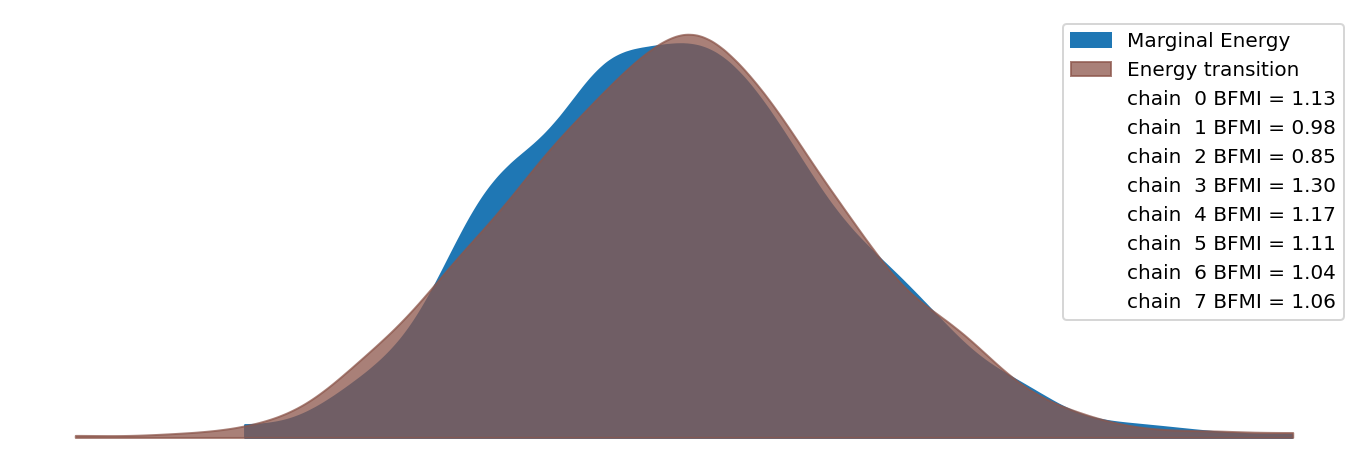

In [13]:
az.plot_energy(idata)

## Posterior Analysis

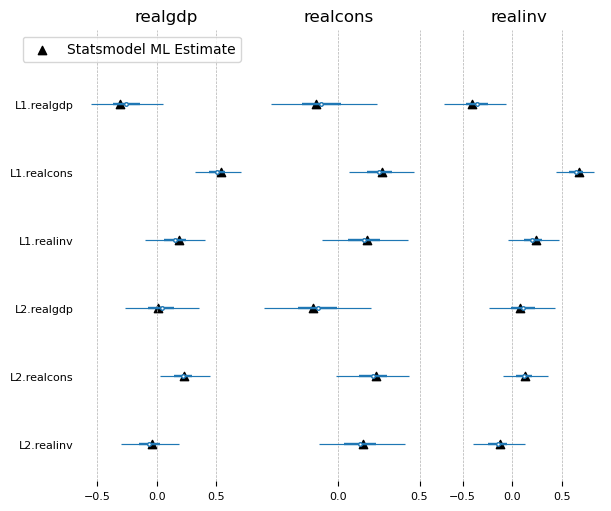

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(6, 5), dpi=100, layout="constrained")

for i, (axis, var) in enumerate(zip(fig.axes, data)):
    az.plot_forest(
        idata.posterior.sel(observed_state=var),
        var_names=["ar_params"],
        ax=axis,
        combined=True,
        textsize=8,
    )
    new_labels = []
    for label in axis.yaxis.get_majorticklabels():
        old_text = "[" + label.get_text().split("[")[-1]
        labels = eval(re.sub(r"([\d\w]+)", r'"\g<1>"', old_text))
        lag, other_var = labels
        new_text = f"L{lag}.{other_var}"
        new_labels.append(new_text)

    sm_varnames = [f"{label}.{var}" for label in new_labels]
    yaxis_grid = axis.yaxis.get_majorticklocs()
    axis.scatter(
        sm_res.params.loc[sm_varnames],
        yaxis_grid,
        marker="^",
        color="k",
        label="Statsmodel ML Estimate",
    )

    if i == 0:
        axis.set_yticklabels(new_labels)
        axis.legend()
    else:
        axis.set_yticklabels([])

    axis.set_title(var, size=12)

In [15]:
idata_post = bvar_mod.sample_conditional_posterior(idata)

Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

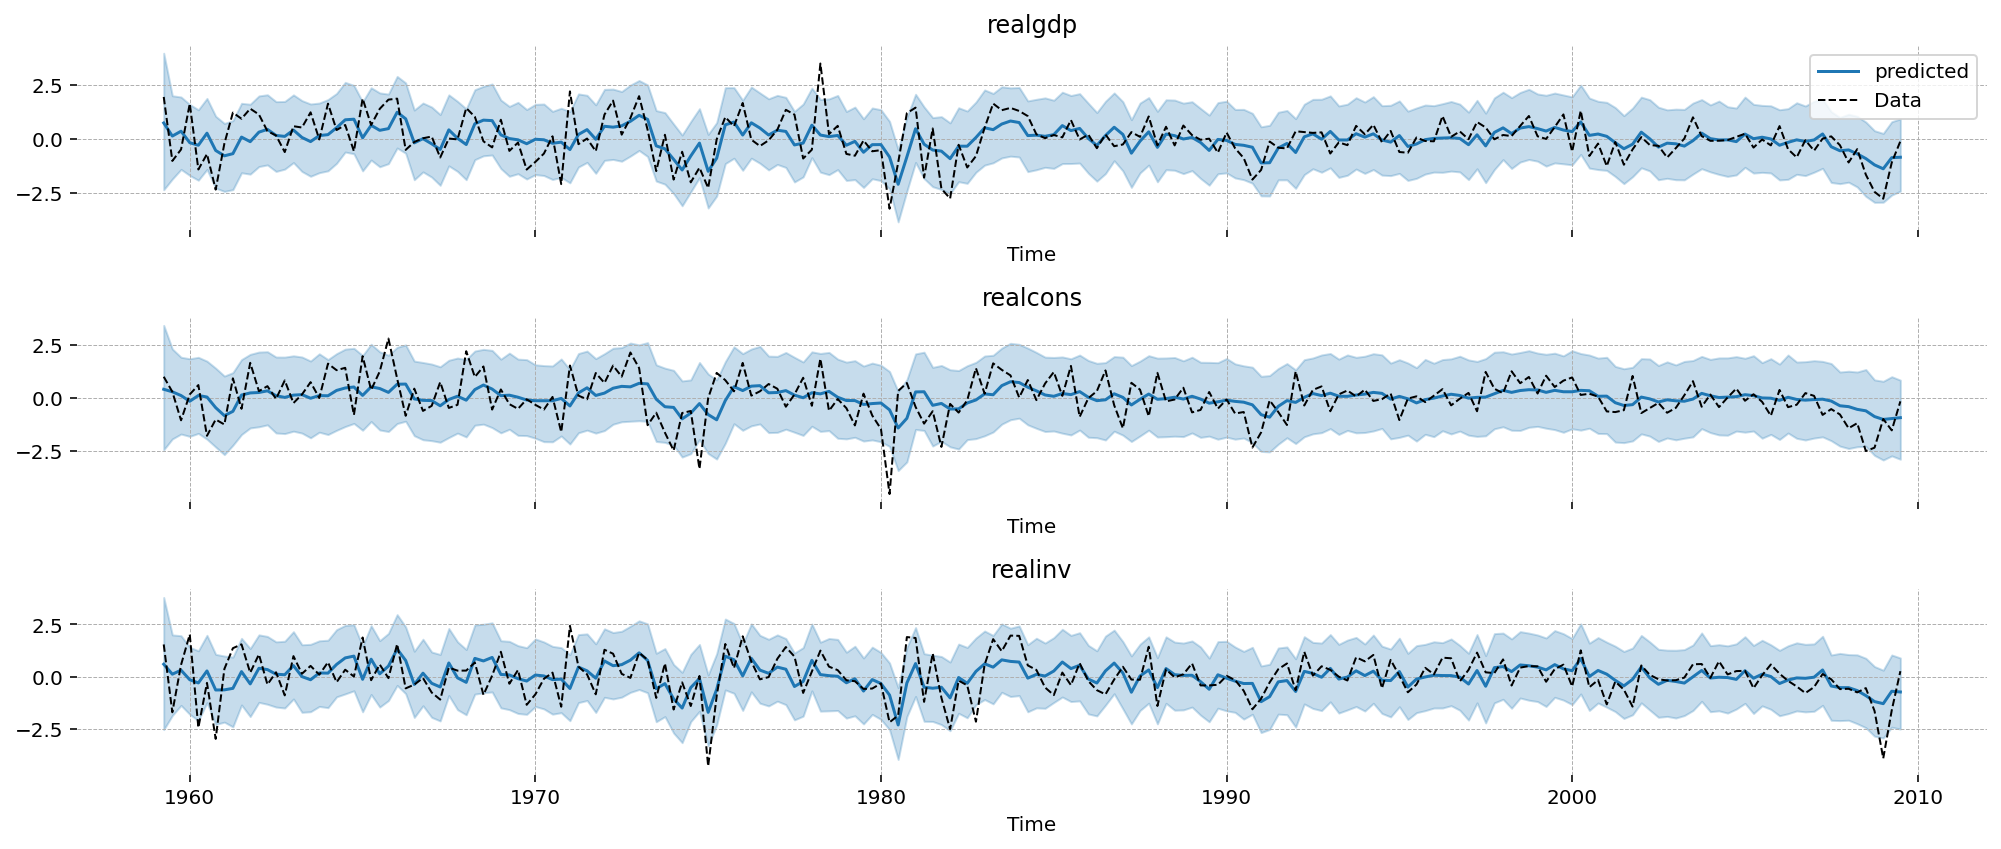

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(14, 6), sharex=True)
filter_output = "predicted"
for i, (var, axis) in enumerate(zip(data, fig.axes)):
    plot_posterior_timeseries(idata_post, var, filter_output, data, ax=axis, add_legend=i == 0)

fig.tight_layout()
plt.show()

# Stability Analysis

We can get posterior eigenvalues of the transition matrix to better understand the range of dynamics our model believes are possible. Unfortunately we can't use `sample_posterior_predictive` to help us do that, because `pt.linalg.eig` discards the imaginary eigenvalues. Instead, we have to use `xarray.apply_ufunc`.  

In [17]:
# By default we don't store the statespace matrices in idata at sampling time, so we need to go back and sample them.
# The sample_statespace_matrices class is a helper to do this.

matrix_idata = bvar_mod.sample_statespace_matrices(idata, ["T"])

Sampling: []


Output()

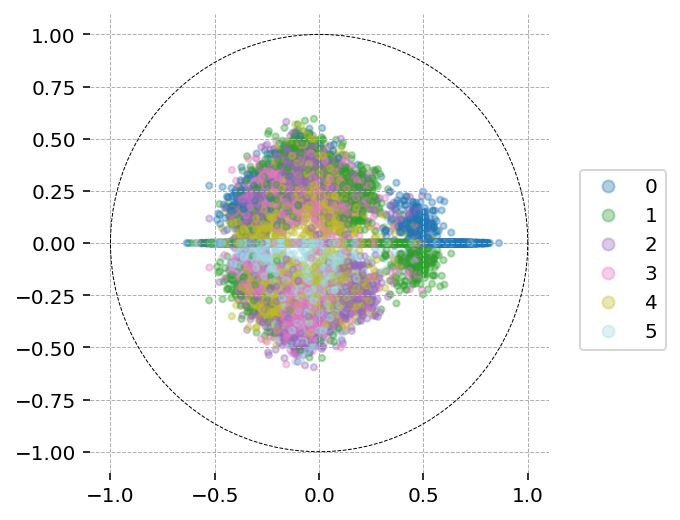

In [18]:
import xarray as xr

eigs = xr.apply_ufunc(
    np.linalg.eigvals,
    matrix_idata.posterior_predictive.T,
    input_core_dims=[["state", "state_aux"]],
    output_core_dims=[["state"]],
)

plot_eigenvalues(eigs.stack(sample=["chain", "draw"]).values.T)

# Impulse Response Function

The API needs some work. By default, all the shocks get mixed up. If you want just one shock, you have to make a custom trajectory for now. Need to think of a way to get shocks as a group into the `idata` returned by `impulse_response_function`

Sampling: []


Output()

Sampling: []


Output()

Sampling: []


Output()

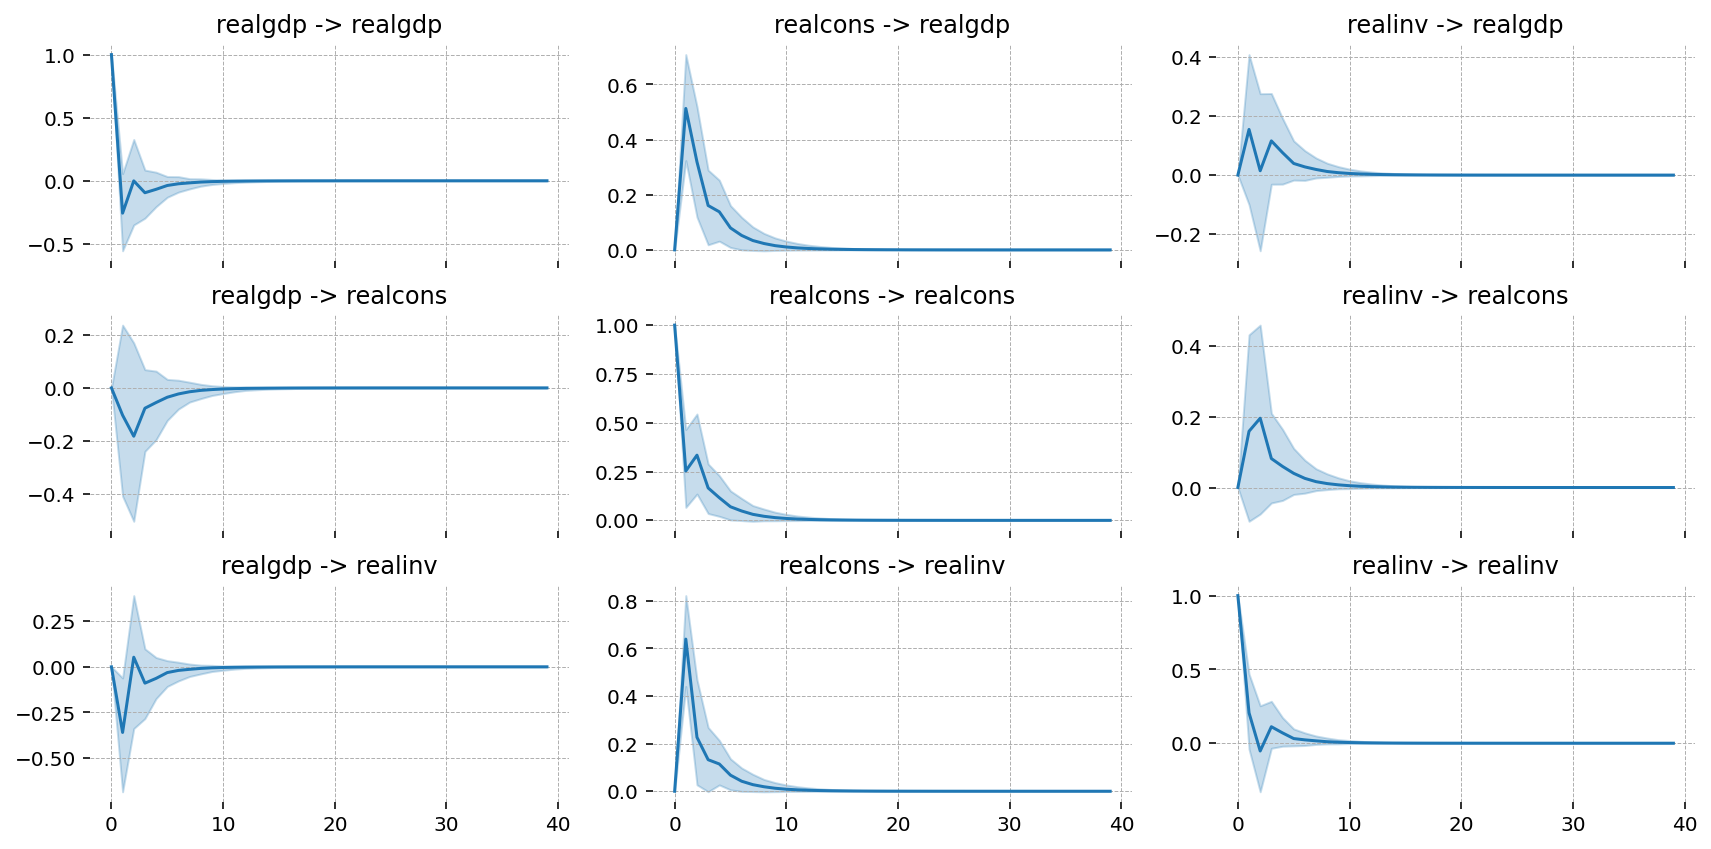

In [19]:
steps = 40
shock_size = 1
n_shocks = bvar_mod.k_posdef

fig, ax = plt.subplots(3, 3, figsize=(12, 6), sharex=True)

for i, shock in enumerate(data):
    shocks = np.zeros(n_shocks)
    shocks[i] = shock_size
    irf_idata = bvar_mod.impulse_response_function(idata, shock_size=shocks, n_steps=steps).irf
    hdi = az.hdi(irf_idata).irf
    x_grid = irf_idata.coords["time"]
    for j, var in enumerate(data):
        axis = ax[j][i]
        axis.plot(x_grid, irf_idata.sel(state=var).mean(dim=["chain", "draw"]).values)
        axis.fill_between(x_grid, *hdi.sel(state=var).values.T, color="tab:blue", alpha=0.25)
        axis.set_title(f"{shock} -> {var}")

fig.tight_layout()

Another interesting thing to do is look at the dynamics of samples where the eigenvalues are maximally imaginary. First of all, it's a sanity check on the `xr.apply_ufunc`, which is non-trivial to use. But secondly, it's interesting to see periodic dynamics. Some macroeconomic models seek imaginary eigenvalues as a way to generating business cycles. 

For this sample, we can see some convergent oscillating behavior in the IRFs.

In [20]:
max_chain, max_draw, _ = np.nonzero(eigs.values.imag == eigs.values.imag.max())

Sampling: []


Output()

Sampling: []


Output()

Sampling: []


Output()

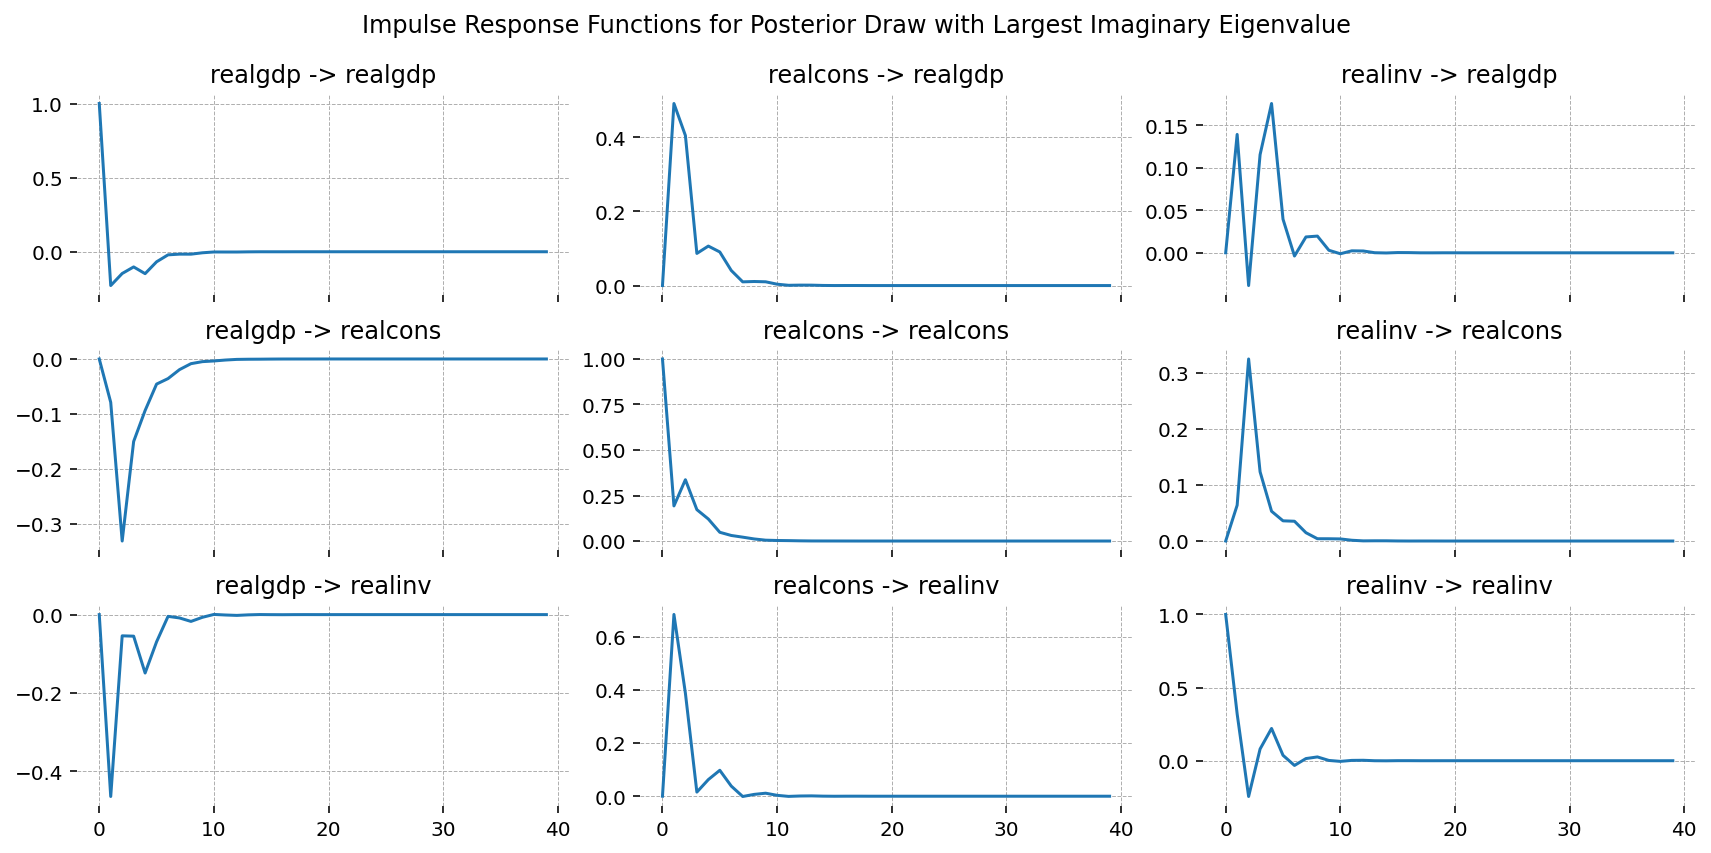

In [21]:
fig, ax = plt.subplots(3, 3, figsize=(12, 6), sharex=True)

for i, shock in enumerate(data):
    shocks = np.zeros(n_shocks)
    shocks[i] = shock_size
    irf_idata = bvar_mod.impulse_response_function(idata, shock_size=shocks, n_steps=steps).irf
    hdi = az.hdi(irf_idata).irf
    x_grid = irf_idata.coords["time"]
    for j, var in enumerate(data):
        axis = ax[j][i]
        axis.plot(x_grid, irf_idata.sel(chain=max_chain, draw=max_draw, state=var).values.squeeze())
        axis.set_title(f"{shock} -> {var}")

fig.suptitle("Impulse Response Functions for Posterior Draw with Largest Imaginary Eigenvalue")
fig.tight_layout()

## Forecasting

Sampling: [forecast_combined]


Output()

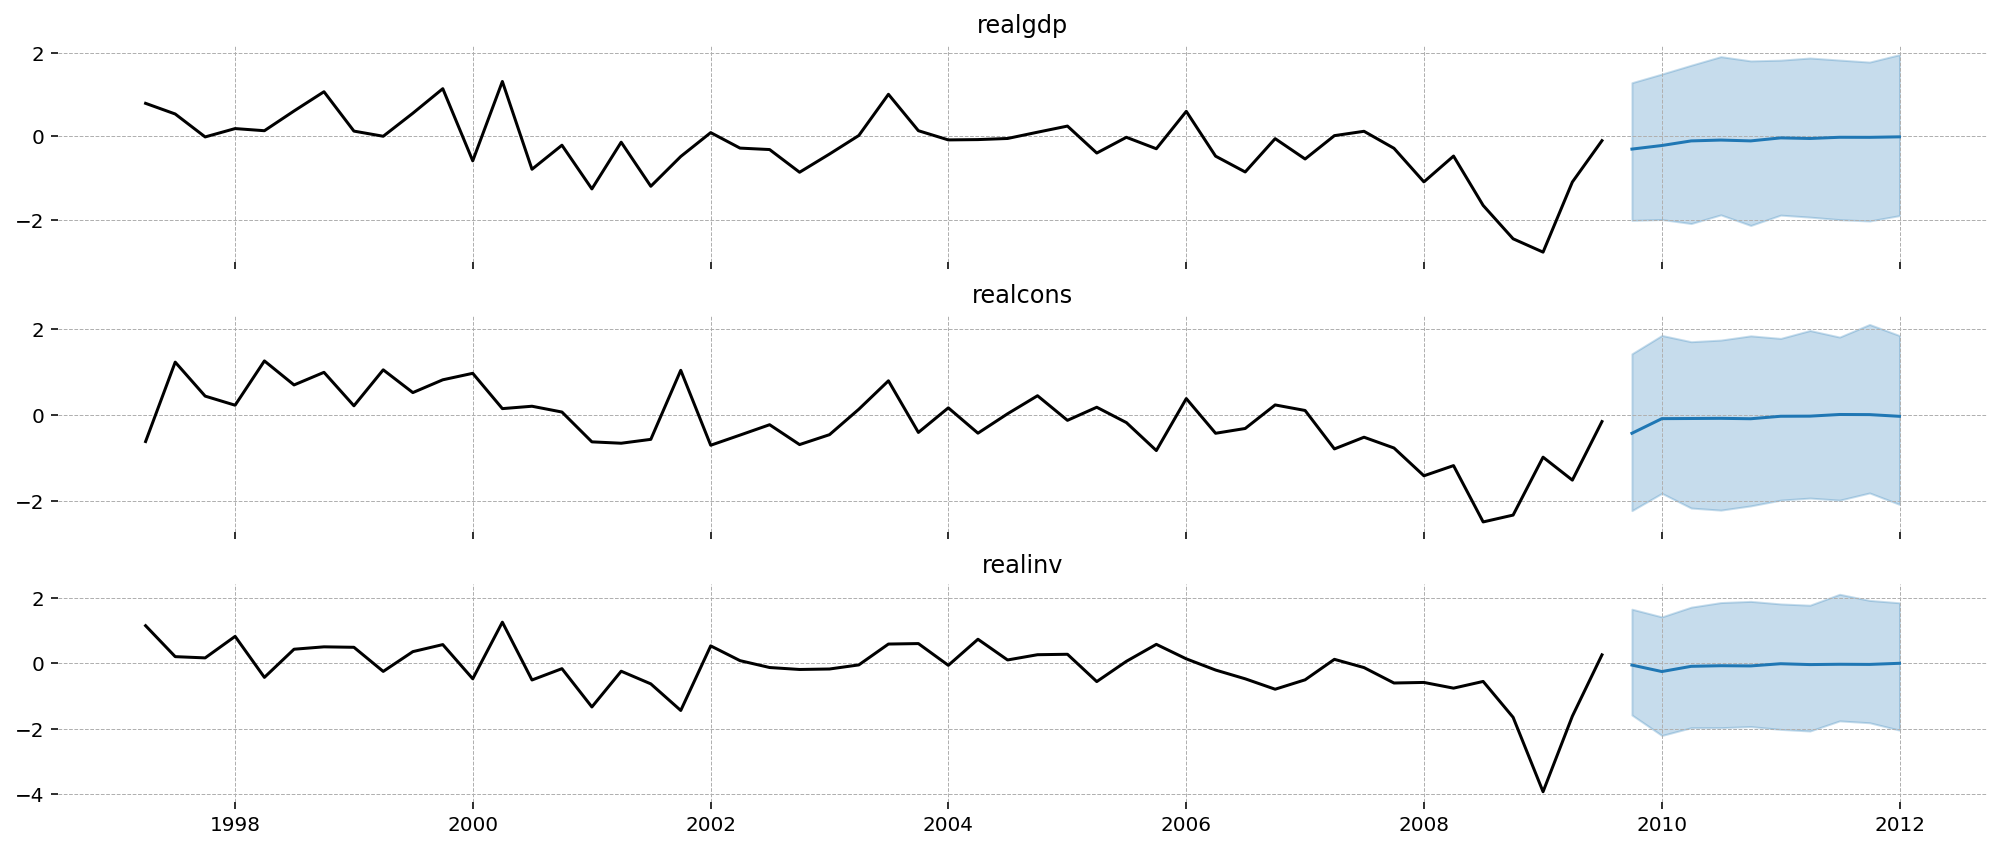

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(14, 6), sharex=True)
forecasts = bvar_mod.forecast(idata, start=data.index[-1], periods=10, filter_output="smoothed")
forecasts = forecasts.forecast_observed
hdi = az.hdi(forecasts).forecast_observed

for state, axis in zip(data, fig.axes):
    x_grid = forecasts.coords["time"]
    axis.plot(data.index[-50:], data[state].values[-50:], c="k")
    axis.plot(x_grid, forecasts.sel(observed_state=state).mean(dim=["chain", "draw"]).values)
    axis.fill_between(x_grid, *hdi.sel(observed_state=state).values.T, color="tab:blue", alpha=0.25)
    axis.set_title(state)
fig.tight_layout()
plt.show()